In [ ]:
!pip install imutils

### Ball XY Coordinate Detection using Color Filtering

In [105]:
def color_filter(image,color):
    '''
    Function used to performed color filtering
    image: The input image on which color filtering is performed
    color: The name of the color which we want to filter
    '''
    #Get a copy of the input image
    result = image.copy()

    #Convert image in HSV color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #Form a mask to filter Red in HSV space
    if color=="red":
        lower1 = np.array([0, 30, 0])
        upper1 = np.array([8, 255,205])
        lower2 = np.array([170,30,0])
        upper2 = np.array([179,255,205])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        mask = lower_mask + upper_mask;

    #Form a mask to filter green in HSV space
    elif color=="green":
        lower1 = np.array([40, 50, 20])
        upper1 = np.array([85, 225, 225])
        mask = cv2.inRange(image, lower1, upper1) 

    #Form a mask to filter Yellow in HSV space
    elif color=="yellow":
        lower1 = np.array([12, 50, 20])
        upper1 = np.array([50, 225, 225])
        mask = cv2.inRange(image, lower1, upper1) 

    #Form a mask to filter Blue in HSV space
    elif color=="blue":
        lower1 = np.array([110, 120, 0])
        upper1 = np.array([135, 255, 255])
        mask = cv2.inRange(image, lower1, upper1) 

    elif color=="white":
        # sensitivity=45
        lower1 = np.array([0,0,175])
        upper1 = np.array([255,255,215])
        mask = cv2.inRange(image, lower1, upper1) 

    elif color=="black":
        # sensitivity=45
        lower1 = np.array([0,0,0])
        upper1 = np.array([100,100,200])
        mask = cv2.inRange(image, lower1, upper1) 

    elif color=="pink":
        # sensitivity=45
        lower1 = np.array([145,110,110])
        upper1 = np.array([255,255,255])
        mask = cv2.inRange(image, lower1, upper1) 

    else:
        print("Error Color Provided Not Valid")
        assert(False)

    #Apply the mask using a bitwise and operator
    result = cv2.bitwise_and(result, result, mask=mask)
    # cv2_imshow(result)
    return result


In [106]:
def get_ball_xy(image,minDist,param1,param2,minRadius,maxRadius):
    '''
    Code based on: https://stackoverflow.com/questions/60637120/detect-circles-in-opencv

    image = input image to detect the circle on
    minDist = Minimum distance between the centers of the detected circles. if too large circles may be missed, if too small too many circles may appear.
    param1= Method uses canny filter edge detection.  This is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller of the larger one).
    param2 = accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected.
    minRadius = min radius of circle to detect 
    maxRadius = max radius of circle to detect
    '''
    #Color Filter tha given image using green
    color='green'
    filtered_img= color_filter (image,color)

    #Converting the image into grayscale
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

    #Smoothening the Image
    blurred = cv2.medianBlur(gray, 25) 

    #Finds circles in a grayscale image using the Hough transform
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

    #If we detected circles with given params
    if circles is not None:
        circles = np.uint16(np.around(circles))

        #Loop through them and draw them on the given image + print coordinates
        for i in circles[0,:]:
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            x_ball=i[0]
            y_ball=i[1]
            # print("x= ",x_ball,"y= ",y_ball)
            cv2.circle(image, (x_ball,y_ball), radius=3, color=(0, 0, 255), thickness=-1)
    else:
        print("Ball Not Found")
        x_ball=-1000
        y_ball=-1000
    
    return x_ball,y_ball



In [107]:
def resize_image(img,percent):
    '''
    img = input image to be resized
    percent = percentage by which to resize the image
    '''
    # percent of original size
    width = int(img.shape[1] * percent / 100)
    height = int(img.shape[0] * percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [108]:
def align_field(image):
    '''Used to align the view of the field into a 2D plane'''

    #Performing Colour Filtering to Distinguish the Field
    color='green'
    result= color_filter (image,color)
    # cv2_imshow(result)
    # Finding Contours to detect the area of the field
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,18,243,0)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # #Taking the one with the largest area
    c = max(contours, key = cv2.contourArea)

    cv2.drawContours(result,contours,-1,(255,0,0))
    # cv2_imshow(result)
    # #Taking its Convex hull to get an aproximate rectangle
    c=cv2.convexHull(c)
    perimeter = cv2.arcLength(c, True)


    #Using an approximate polygon to get the corners of the rectangle
    approx= cv2.approxPolyDP(c, 0.05 * perimeter, True)
    corners=np.zeros((4,2),dtype=np.int16)
    i=0

    #if the contours detected don't form a rectangle then we approximate them using a minimum rectangle area
    if len(approx)>4:
        hull =[]
        for c in contours:
            if cv2.contourArea(c)>10:
                hull.append(cv2.convexHull(c,False))
        rect = cv2.minAreaRect(np.concatenate(hull,axis=0))
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(result,[box],0,(0,0,255),2)
        c=box
        approx= cv2.approxPolyDP(c, 0.05 * perimeter, True)


    #Drawing a circle at every corner of the field and converting the list of corner points to array
    for point in approx:
        x, y = point[0]
        corners[i,0]=x
        corners[i,1]=y    
        cv2.circle(result, (x, y), 3, (0, 255, 0), -1)
        i=i+1


    #Calculating the pairwise distance between every corner point
    dist=scipy.spatial.distance.pdist(corners,'euclidean')
    #Getting rid of the diagonals as they are the two longest distances
    edges=np.sort(dist)[:4]
    #Since the edges array is sorted the two smallest values are the width and the others are length
    width = edges[:2]
    length = edges[2:]

    #Getting Max length and width
    # if image.shape[0]>image.shape[1]:
    #   maxWidth=max(np.max((width).astype(int)),np.max((length).astype(int)))
    #   maxLength=min(np.max((width).astype(int)),np.max((length).astype(int)))
    # else:
    maxWidth=np.max((width).astype(int))
    maxLength=np.max((length).astype(int))

    #Converting to float the distorted rectangle
    input_pts=np.float32(corners)
    #Building a matrix with the ideal rectangle points (i.e. max distances)
    output_pts = np.float32([[0, 0],
                          [0, maxLength - 1],
                          [maxWidth - 1, maxLength - 1],
                          [maxWidth - 1, 0]])

    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts,output_pts)

    #Wrapping the image based on the perspective transform
    out = cv2.warpPerspective(image,M,(maxWidth, maxLength),flags=cv2.INTER_LINEAR)
    return out

In [109]:
def detect_box(image,color):
    blurred_image = cv2.GaussianBlur(image,(17,17),cv2.BORDER_DEFAULT)
    #Color filtering in yellow
    result3= color_filter (blurred_image,color)
    plt.imshow(cv2.cvtColor(result3, cv2.COLOR_BGR2RGB))
    plt.show()
    #Contour DEtection
    gray = cv2.cvtColor(result3, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,12,243,0)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Taking contour with biggest area
    cnt= max(contours, key = cv2.contourArea)

    #Forming a rectangle of min area arround them
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    #Contour drawing
    # cv2.drawContours(resized_image,[box],0,(0,0,255),2)

    #Calculating centroid of rectangle using moments
    M = cv2.moments(box)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    # cv2.circle(resized_image,(cx,cy),1,(0,255,0),12)

    return cx,cy


def get_robot_pose (image):

    #Detect the yellow box
    cx_yellow,cy_yellow=detect_box(image,'yellow')

    #Detect the red box
    cx_red,cy_red=detect_box(image,'blue')



    #Save red box center as robot's xy
    robot_xy=(cx_red,cy_red)

    #Draw orientation Vector using yellow and red box centroids
    cv2.arrowedLine(image,(cx_red,cy_red),(cx_yellow,cy_yellow),(255,0,0),3)

    #Draw Point for Centroid of Robot
    cv2.circle(image,(cx_red,cy_red),1,(0,255,0),12)

    # cv2_imshow(image)

    #Calculating the angle of the robot

    #First calculating the horizontal and vertical displacements
    dy=(cy_yellow-cx_red)
    dx=(cx_yellow-cx_red)

    #Calculating the angle between the two dx dy
    #We return the negative value because the origin of image is on the top left corner but by convention we take it at the bottom
    robot_angle=-math.atan2(dx,dy)
    return robot_xy,robot_angle

In [110]:
def draw_origin(image):
    '''
    Used to draw the origin on the image's left corner
    '''
    im_size=np.shape(image)
    font = cv2.FONT_HERSHEY_SIMPLEX

    #Drawing x-axis
    cv2.arrowedLine(image, (5, im_size[0]-10), (45, im_size[0]-10), (0,0, 255), thickness=2)
    cv2.putText(image, 'x', (45+15, im_size[0]-10), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    #Drawing y-axis
    cv2.arrowedLine(image, (5, im_size[0]-10), (5, -35+im_size[0]-10), (0,0, 255), thickness=2)
    cv2.putText(image, 'y', (5+15, -35+im_size[0]-10), font, 1, (0, 0, 255), 2, cv2.LINE_AA)


In [115]:
def generate_map(image):
    blurred_image_red = cv2.GaussianBlur(image,(19,19),cv2.BORDER_DEFAULT)
    image_red=color_filter(blurred_image_red,'pink')
    kernel = np.ones((5,5),np.uint8)
    
    map=np.empty_like(image_red)

    map[image_red!=0]=0
    map[image_red==0]=255
    erosion = cv2.erode(map,kernel,iterations = 7)
    
    print("Map")
    plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return map

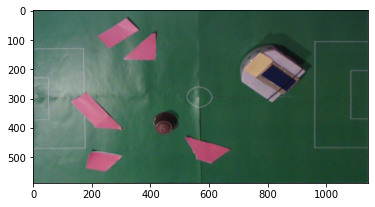

Map


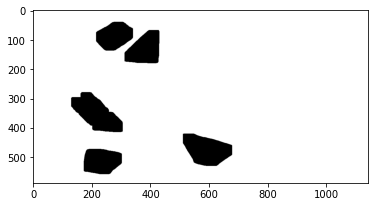

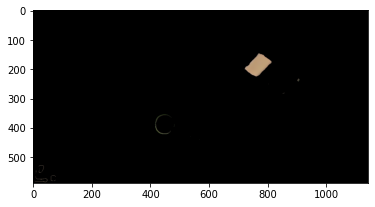

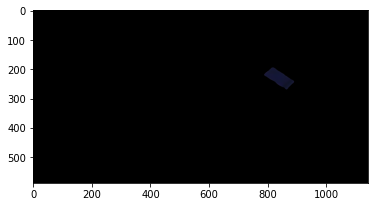

Ball_XY:  450 388
Robot_XY:  838 230
Robot_theta:  173.68878942486737


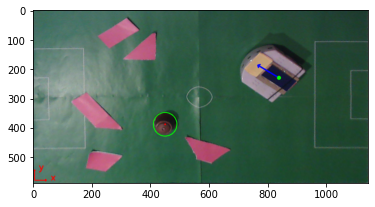

In [116]:
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
import scipy.spatial.distance
import math
import imutils
import matplotlib.pyplot as plt
%matplotlib inline

# orig_image = cv2.imread('/content/drive/MyDrive/images/scene-4.jpeg')
# orig_image = cv2.imread('/content/drive/MyDrive/images/test/opencv_frame_3.png')
orig_image = cv2.imread('./pink_obs3.jpg')
# cv2_imshow(orig_image)
image=resize_image(orig_image,80)

image=align_field(image)

image=cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

x_ball,y_ball=get_ball_xy(image, 
            minDist = 550,
            param1 = 30, 
            param2 = 19, 
            minRadius = 20,
            maxRadius = 55)

map = generate_map(image)
draw_origin(image)
robot_xy,robot_angle=get_robot_pose(image)


print("Ball_XY: ",x_ball,y_ball)
print("Robot_XY: ",robot_xy[0],robot_xy[1])
print("Robot_theta: ",math.degrees(robot_angle))


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
